In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.models as models
from pydantic.experimental.pipeline import transform
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
plt.style.use('ggplot')

REZNET модель

In [46]:
model = models.resnet50(pretrained=False)
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [4]:
num_classes = 10
def reznet18_for_cifar10():
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(512, num_classes)
    return model
    

In [5]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])


train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

train_batch_size = 512
test_batch_size = 512

train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
model = reznet18_for_cifar10()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

num_epochs = 200

model.to(device)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
best_test_accuracy = 0
patience_counter = 0
MAX_PATIENCE = 20

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_correct = 0
    
    model.train()
    
    for images, labels in tqdm(train_loader, leave=True):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        train_running_loss += loss.item()
        
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(labels).sum().item()
        
    train_loss = train_running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = train_correct / len(train_set)
    train_accuracies.append(train_accuracy)
    
    
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_running_loss += loss.item()
            
            _, predicted = outputs.max(1)
            test_correct += predicted.eq(labels).sum().item()
            
    test_loss = test_running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = test_correct / len(test_set)
    test_accuracies.append(test_accuracy)
    
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step()
    
    print(f'Epoch: [{epoch+1}/{num_epochs}], train_loss = {train_loss:.4f}, train_acc = {train_accuracy:.4f}, test_loss = {test_loss:.4f}, test_accuracy = {test_accuracy:.4f}')
    
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        patience_counter = 0
        
        print(f'Сохранена новая лучшая модель: {test_accuracy:.4f}')
        
        PATH = 'models/cifar_reznet_best.pth'
        torch.save(model.state_dict(), PATH)
        
        accuracy_percent = int(test_accuracy * 10000)  # 93.61% -> 9361
        BACKUP_PATH = f'models/cifar_reznet_{accuracy_percent}.pth'
        torch.save(model.state_dict(), BACKUP_PATH)
    else:
        patience_counter += 1
        print(f'Без улучшения {patience_counter}/{MAX_PATIENCE} эпох')
    
        if patience_counter >= MAX_PATIENCE:
            print(" Ранняя остановка, нет улучшений")
            break
            
print('Сохранена последняя модель')
PATH = 'models/cifar_reznet_last.pth'
torch.save(model.state_dict(), PATH)
print('Закончили обучение')

C:\Users\Devourer\AppData\Local\pypoetry\Cache\virtualenvs\ai-test-task-O710Er_i-py3.13\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Devourer\AppData\Local\pypoetry\Cache\virtualenvs\ai-test-task-O710Er_i-py3.13\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 98/98 [00:21<00:00,  4.58it/s]


Epoch: [1/200], train_loss = 2.2276, train_acc = 0.2209, test_loss = 1.7584, test_accuracy = 0.3293
Сохранена новая лучшая модель: 0.3293


100%|██████████| 98/98 [00:21<00:00,  4.47it/s]


Epoch: [2/200], train_loss = 1.6638, train_acc = 0.3756, test_loss = 1.5137, test_accuracy = 0.4342
Сохранена новая лучшая модель: 0.4342


100%|██████████| 98/98 [00:21<00:00,  4.54it/s]


Epoch: [3/200], train_loss = 1.4304, train_acc = 0.4744, test_loss = 1.8077, test_accuracy = 0.4261
Без улучшения 1/20 эпох


100%|██████████| 98/98 [00:21<00:00,  4.56it/s]


Epoch: [4/200], train_loss = 1.2404, train_acc = 0.5480, test_loss = 1.2569, test_accuracy = 0.5660
Сохранена новая лучшая модель: 0.5660


100%|██████████| 98/98 [00:20<00:00,  4.69it/s]


Epoch: [5/200], train_loss = 1.0669, train_acc = 0.6197, test_loss = 1.2103, test_accuracy = 0.5939
Сохранена новая лучшая модель: 0.5939


100%|██████████| 98/98 [00:22<00:00,  4.32it/s]


Epoch: [6/200], train_loss = 0.9422, train_acc = 0.6646, test_loss = 0.9732, test_accuracy = 0.6664
Сохранена новая лучшая модель: 0.6664


100%|██████████| 98/98 [00:21<00:00,  4.49it/s]


Epoch: [7/200], train_loss = 0.8299, train_acc = 0.7069, test_loss = 0.7607, test_accuracy = 0.7304
Сохранена новая лучшая модель: 0.7304


100%|██████████| 98/98 [00:20<00:00,  4.71it/s]


Epoch: [8/200], train_loss = 0.7385, train_acc = 0.7397, test_loss = 0.7053, test_accuracy = 0.7572
Сохранена новая лучшая модель: 0.7572


100%|██████████| 98/98 [00:21<00:00,  4.58it/s]


Epoch: [9/200], train_loss = 0.6715, train_acc = 0.7653, test_loss = 0.9485, test_accuracy = 0.7045
Без улучшения 1/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.78it/s]


Epoch: [10/200], train_loss = 0.6139, train_acc = 0.7865, test_loss = 0.7315, test_accuracy = 0.7499
Без улучшения 2/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Epoch: [11/200], train_loss = 0.5809, train_acc = 0.7979, test_loss = 0.8079, test_accuracy = 0.7377
Без улучшения 3/20 эпох


100%|██████████| 98/98 [00:19<00:00,  4.94it/s]


Epoch: [12/200], train_loss = 0.5450, train_acc = 0.8100, test_loss = 0.6016, test_accuracy = 0.7979
Сохранена новая лучшая модель: 0.7979


100%|██████████| 98/98 [00:20<00:00,  4.73it/s]


Epoch: [13/200], train_loss = 0.5136, train_acc = 0.8232, test_loss = 0.5174, test_accuracy = 0.8211
Сохранена новая лучшая модель: 0.8211


100%|██████████| 98/98 [00:20<00:00,  4.76it/s]


Epoch: [14/200], train_loss = 0.4979, train_acc = 0.8261, test_loss = 0.5175, test_accuracy = 0.8262
Сохранена новая лучшая модель: 0.8262


100%|██████████| 98/98 [00:20<00:00,  4.76it/s]


Epoch: [15/200], train_loss = 0.4755, train_acc = 0.8349, test_loss = 0.5041, test_accuracy = 0.8289
Сохранена новая лучшая модель: 0.8289


100%|██████████| 98/98 [00:20<00:00,  4.71it/s]


Epoch: [16/200], train_loss = 0.4605, train_acc = 0.8410, test_loss = 0.9986, test_accuracy = 0.7047
Без улучшения 1/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.83it/s]


Epoch: [17/200], train_loss = 0.4462, train_acc = 0.8472, test_loss = 0.5145, test_accuracy = 0.8254
Без улучшения 2/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.78it/s]


Epoch: [18/200], train_loss = 0.4379, train_acc = 0.8501, test_loss = 0.5712, test_accuracy = 0.8133
Без улучшения 3/20 эпох


100%|██████████| 98/98 [00:19<00:00,  4.91it/s]


Epoch: [19/200], train_loss = 0.4205, train_acc = 0.8545, test_loss = 0.6355, test_accuracy = 0.7990
Без улучшения 4/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.88it/s]


Epoch: [20/200], train_loss = 0.4123, train_acc = 0.8581, test_loss = 0.4865, test_accuracy = 0.8388
Сохранена новая лучшая модель: 0.8388


100%|██████████| 98/98 [00:20<00:00,  4.74it/s]


Epoch: [21/200], train_loss = 0.4035, train_acc = 0.8601, test_loss = 0.4601, test_accuracy = 0.8447
Сохранена новая лучшая модель: 0.8447


100%|██████████| 98/98 [00:20<00:00,  4.76it/s]


Epoch: [22/200], train_loss = 0.4022, train_acc = 0.8619, test_loss = 0.4705, test_accuracy = 0.8448
Сохранена новая лучшая модель: 0.8448


100%|██████████| 98/98 [00:20<00:00,  4.67it/s]


Epoch: [23/200], train_loss = 0.3931, train_acc = 0.8647, test_loss = 0.5186, test_accuracy = 0.8221
Без улучшения 1/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


Epoch: [24/200], train_loss = 0.3919, train_acc = 0.8663, test_loss = 0.5207, test_accuracy = 0.8241
Без улучшения 2/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.78it/s]


Epoch: [25/200], train_loss = 0.3822, train_acc = 0.8697, test_loss = 0.4903, test_accuracy = 0.8368
Без улучшения 3/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.89it/s]


Epoch: [26/200], train_loss = 0.3736, train_acc = 0.8707, test_loss = 0.5440, test_accuracy = 0.8242
Без улучшения 4/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.80it/s]


Epoch: [27/200], train_loss = 0.3709, train_acc = 0.8717, test_loss = 0.4084, test_accuracy = 0.8575
Сохранена новая лучшая модель: 0.8575


100%|██████████| 98/98 [00:20<00:00,  4.75it/s]


Epoch: [28/200], train_loss = 0.3643, train_acc = 0.8755, test_loss = 0.5526, test_accuracy = 0.8197
Без улучшения 1/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


Epoch: [29/200], train_loss = 0.3621, train_acc = 0.8758, test_loss = 0.4920, test_accuracy = 0.8362
Без улучшения 2/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.72it/s]


Epoch: [30/200], train_loss = 0.3643, train_acc = 0.8748, test_loss = 0.5018, test_accuracy = 0.8384
Без улучшения 3/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.78it/s]


Epoch: [31/200], train_loss = 0.2417, train_acc = 0.9189, test_loss = 0.2393, test_accuracy = 0.9187
Сохранена новая лучшая модель: 0.9187


100%|██████████| 98/98 [00:20<00:00,  4.76it/s]


Epoch: [32/200], train_loss = 0.1935, train_acc = 0.9359, test_loss = 0.2261, test_accuracy = 0.9217
Сохранена новая лучшая модель: 0.9217


100%|██████████| 98/98 [00:23<00:00,  4.21it/s]


Epoch: [33/200], train_loss = 0.1733, train_acc = 0.9423, test_loss = 0.2220, test_accuracy = 0.9260
Сохранена новая лучшая модель: 0.9260


100%|██████████| 98/98 [00:22<00:00,  4.26it/s]


Epoch: [34/200], train_loss = 0.1604, train_acc = 0.9466, test_loss = 0.2125, test_accuracy = 0.9271
Сохранена новая лучшая модель: 0.9271


100%|██████████| 98/98 [00:20<00:00,  4.85it/s]


Epoch: [35/200], train_loss = 0.1534, train_acc = 0.9485, test_loss = 0.2148, test_accuracy = 0.9276
Сохранена новая лучшая модель: 0.9276


100%|██████████| 98/98 [00:20<00:00,  4.73it/s]


Epoch: [36/200], train_loss = 0.1425, train_acc = 0.9518, test_loss = 0.2133, test_accuracy = 0.9280
Сохранена новая лучшая модель: 0.9280


100%|██████████| 98/98 [00:20<00:00,  4.67it/s]


Epoch: [37/200], train_loss = 0.1393, train_acc = 0.9527, test_loss = 0.2056, test_accuracy = 0.9293
Сохранена новая лучшая модель: 0.9293


100%|██████████| 98/98 [00:20<00:00,  4.76it/s]


Epoch: [38/200], train_loss = 0.1286, train_acc = 0.9564, test_loss = 0.2087, test_accuracy = 0.9305
Сохранена новая лучшая модель: 0.9305


100%|██████████| 98/98 [00:20<00:00,  4.72it/s]


Epoch: [39/200], train_loss = 0.1244, train_acc = 0.9572, test_loss = 0.2162, test_accuracy = 0.9299
Без улучшения 1/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.68it/s]


Epoch: [40/200], train_loss = 0.1201, train_acc = 0.9599, test_loss = 0.2197, test_accuracy = 0.9283
Без улучшения 2/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.82it/s]


Epoch: [41/200], train_loss = 0.1152, train_acc = 0.9614, test_loss = 0.2175, test_accuracy = 0.9290
Без улучшения 3/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.87it/s]


Epoch: [42/200], train_loss = 0.1095, train_acc = 0.9626, test_loss = 0.2086, test_accuracy = 0.9314
Сохранена новая лучшая модель: 0.9314


100%|██████████| 98/98 [00:20<00:00,  4.79it/s]


Epoch: [43/200], train_loss = 0.1039, train_acc = 0.9645, test_loss = 0.2237, test_accuracy = 0.9288
Без улучшения 1/20 эпох


100%|██████████| 98/98 [00:21<00:00,  4.63it/s]


Epoch: [44/200], train_loss = 0.1044, train_acc = 0.9648, test_loss = 0.2281, test_accuracy = 0.9278
Без улучшения 2/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


Epoch: [45/200], train_loss = 0.0985, train_acc = 0.9666, test_loss = 0.2150, test_accuracy = 0.9294
Без улучшения 3/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


Epoch: [46/200], train_loss = 0.0952, train_acc = 0.9677, test_loss = 0.2311, test_accuracy = 0.9269
Без улучшения 4/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.79it/s]


Epoch: [47/200], train_loss = 0.0908, train_acc = 0.9694, test_loss = 0.2349, test_accuracy = 0.9254
Без улучшения 5/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.89it/s]


Epoch: [48/200], train_loss = 0.0864, train_acc = 0.9716, test_loss = 0.2190, test_accuracy = 0.9278
Без улучшения 6/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.77it/s]


Epoch: [49/200], train_loss = 0.0836, train_acc = 0.9718, test_loss = 0.2371, test_accuracy = 0.9239
Без улучшения 7/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Epoch: [50/200], train_loss = 0.0843, train_acc = 0.9716, test_loss = 0.2331, test_accuracy = 0.9279
Без улучшения 8/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Epoch: [51/200], train_loss = 0.0832, train_acc = 0.9727, test_loss = 0.2316, test_accuracy = 0.9285
Без улучшения 9/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.76it/s]


Epoch: [52/200], train_loss = 0.0780, train_acc = 0.9744, test_loss = 0.2315, test_accuracy = 0.9296
Без улучшения 10/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.80it/s]


Epoch: [53/200], train_loss = 0.0770, train_acc = 0.9744, test_loss = 0.2409, test_accuracy = 0.9259
Без улучшения 11/20 эпох


100%|██████████| 98/98 [00:21<00:00,  4.61it/s]


Epoch: [54/200], train_loss = 0.0737, train_acc = 0.9757, test_loss = 0.2470, test_accuracy = 0.9263
Без улучшения 12/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.85it/s]


Epoch: [55/200], train_loss = 0.0747, train_acc = 0.9749, test_loss = 0.2392, test_accuracy = 0.9264
Без улучшения 13/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.85it/s]


Epoch: [56/200], train_loss = 0.0727, train_acc = 0.9762, test_loss = 0.2418, test_accuracy = 0.9277
Без улучшения 14/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.78it/s]


Epoch: [57/200], train_loss = 0.0695, train_acc = 0.9769, test_loss = 0.2450, test_accuracy = 0.9278
Без улучшения 15/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.88it/s]


Epoch: [58/200], train_loss = 0.0714, train_acc = 0.9761, test_loss = 0.2323, test_accuracy = 0.9312
Без улучшения 16/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.88it/s]


Epoch: [59/200], train_loss = 0.0671, train_acc = 0.9773, test_loss = 0.2513, test_accuracy = 0.9287
Без улучшения 17/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.82it/s]


Epoch: [60/200], train_loss = 0.0697, train_acc = 0.9772, test_loss = 0.2481, test_accuracy = 0.9253
Без улучшения 18/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.83it/s]


Epoch: [61/200], train_loss = 0.0511, train_acc = 0.9839, test_loss = 0.2098, test_accuracy = 0.9372
Сохранена новая лучшая модель: 0.9372


100%|██████████| 98/98 [00:20<00:00,  4.72it/s]


Epoch: [62/200], train_loss = 0.0427, train_acc = 0.9868, test_loss = 0.2064, test_accuracy = 0.9379
Сохранена новая лучшая модель: 0.9379


100%|██████████| 98/98 [00:20<00:00,  4.86it/s]


Epoch: [63/200], train_loss = 0.0415, train_acc = 0.9873, test_loss = 0.2053, test_accuracy = 0.9382
Сохранена новая лучшая модель: 0.9382


100%|██████████| 98/98 [00:20<00:00,  4.79it/s]


Epoch: [64/200], train_loss = 0.0354, train_acc = 0.9895, test_loss = 0.2050, test_accuracy = 0.9379
Без улучшения 1/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.88it/s]


Epoch: [65/200], train_loss = 0.0360, train_acc = 0.9891, test_loss = 0.2064, test_accuracy = 0.9379
Без улучшения 2/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.85it/s]


Epoch: [66/200], train_loss = 0.0335, train_acc = 0.9899, test_loss = 0.2045, test_accuracy = 0.9381
Без улучшения 3/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.86it/s]


Epoch: [67/200], train_loss = 0.0333, train_acc = 0.9906, test_loss = 0.2054, test_accuracy = 0.9388
Сохранена новая лучшая модель: 0.9388


100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Epoch: [68/200], train_loss = 0.0321, train_acc = 0.9906, test_loss = 0.2056, test_accuracy = 0.9384
Без улучшения 1/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.87it/s]


Epoch: [69/200], train_loss = 0.0320, train_acc = 0.9907, test_loss = 0.2068, test_accuracy = 0.9382
Без улучшения 2/20 эпох


100%|██████████| 98/98 [00:19<00:00,  4.94it/s]


Epoch: [70/200], train_loss = 0.0313, train_acc = 0.9905, test_loss = 0.2067, test_accuracy = 0.9388
Без улучшения 3/20 эпох


100%|██████████| 98/98 [00:21<00:00,  4.56it/s]


Epoch: [71/200], train_loss = 0.0314, train_acc = 0.9912, test_loss = 0.2055, test_accuracy = 0.9379
Без улучшения 4/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.79it/s]


Epoch: [72/200], train_loss = 0.0294, train_acc = 0.9918, test_loss = 0.2064, test_accuracy = 0.9377
Без улучшения 5/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Epoch: [73/200], train_loss = 0.0304, train_acc = 0.9910, test_loss = 0.2064, test_accuracy = 0.9393
Сохранена новая лучшая модель: 0.9393


100%|██████████| 98/98 [00:20<00:00,  4.69it/s]


Epoch: [74/200], train_loss = 0.0289, train_acc = 0.9921, test_loss = 0.2056, test_accuracy = 0.9391
Без улучшения 1/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.79it/s]


Epoch: [75/200], train_loss = 0.0279, train_acc = 0.9921, test_loss = 0.2049, test_accuracy = 0.9390
Без улучшения 2/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.78it/s]


Epoch: [76/200], train_loss = 0.0285, train_acc = 0.9920, test_loss = 0.2055, test_accuracy = 0.9389
Без улучшения 3/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Epoch: [77/200], train_loss = 0.0276, train_acc = 0.9923, test_loss = 0.2082, test_accuracy = 0.9386
Без улучшения 4/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.74it/s]


Epoch: [78/200], train_loss = 0.0282, train_acc = 0.9920, test_loss = 0.2080, test_accuracy = 0.9387
Без улучшения 5/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.79it/s]


Epoch: [79/200], train_loss = 0.0286, train_acc = 0.9921, test_loss = 0.2072, test_accuracy = 0.9389
Без улучшения 6/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.77it/s]


Epoch: [80/200], train_loss = 0.0275, train_acc = 0.9925, test_loss = 0.2088, test_accuracy = 0.9384
Без улучшения 7/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.83it/s]


Epoch: [81/200], train_loss = 0.0262, train_acc = 0.9926, test_loss = 0.2080, test_accuracy = 0.9374
Без улучшения 8/20 эпох


100%|██████████| 98/98 [00:21<00:00,  4.64it/s]


Epoch: [82/200], train_loss = 0.0249, train_acc = 0.9927, test_loss = 0.2083, test_accuracy = 0.9381
Без улучшения 9/20 эпох


100%|██████████| 98/98 [00:21<00:00,  4.66it/s]


Epoch: [83/200], train_loss = 0.0252, train_acc = 0.9929, test_loss = 0.2077, test_accuracy = 0.9388
Без улучшения 10/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.82it/s]


Epoch: [84/200], train_loss = 0.0259, train_acc = 0.9926, test_loss = 0.2078, test_accuracy = 0.9395
Сохранена новая лучшая модель: 0.9395


100%|██████████| 98/98 [00:20<00:00,  4.78it/s]


Epoch: [85/200], train_loss = 0.0250, train_acc = 0.9931, test_loss = 0.2076, test_accuracy = 0.9396
Сохранена новая лучшая модель: 0.9396


100%|██████████| 98/98 [00:20<00:00,  4.72it/s]


Epoch: [86/200], train_loss = 0.0249, train_acc = 0.9934, test_loss = 0.2090, test_accuracy = 0.9387
Без улучшения 1/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.70it/s]


Epoch: [87/200], train_loss = 0.0241, train_acc = 0.9931, test_loss = 0.2068, test_accuracy = 0.9390
Без улучшения 2/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.71it/s]


Epoch: [88/200], train_loss = 0.0233, train_acc = 0.9937, test_loss = 0.2092, test_accuracy = 0.9383
Без улучшения 3/20 эпох


100%|██████████| 98/98 [00:21<00:00,  4.57it/s]


Epoch: [89/200], train_loss = 0.0249, train_acc = 0.9932, test_loss = 0.2088, test_accuracy = 0.9388
Без улучшения 4/20 эпох


100%|██████████| 98/98 [00:21<00:00,  4.65it/s]


Epoch: [90/200], train_loss = 0.0245, train_acc = 0.9930, test_loss = 0.2109, test_accuracy = 0.9389
Без улучшения 5/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.69it/s]


Epoch: [91/200], train_loss = 0.0226, train_acc = 0.9939, test_loss = 0.2101, test_accuracy = 0.9387
Без улучшения 6/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.72it/s]


Epoch: [92/200], train_loss = 0.0225, train_acc = 0.9936, test_loss = 0.2087, test_accuracy = 0.9391
Без улучшения 7/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


Epoch: [93/200], train_loss = 0.0223, train_acc = 0.9939, test_loss = 0.2086, test_accuracy = 0.9387
Без улучшения 8/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.86it/s]


Epoch: [94/200], train_loss = 0.0225, train_acc = 0.9934, test_loss = 0.2086, test_accuracy = 0.9387
Без улучшения 9/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.79it/s]


Epoch: [95/200], train_loss = 0.0232, train_acc = 0.9937, test_loss = 0.2090, test_accuracy = 0.9389
Без улучшения 10/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.82it/s]


Epoch: [96/200], train_loss = 0.0223, train_acc = 0.9938, test_loss = 0.2074, test_accuracy = 0.9391
Без улучшения 11/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.78it/s]


Epoch: [97/200], train_loss = 0.0228, train_acc = 0.9935, test_loss = 0.2075, test_accuracy = 0.9387
Без улучшения 12/20 эпох


100%|██████████| 98/98 [00:19<00:00,  4.91it/s]


Epoch: [98/200], train_loss = 0.0226, train_acc = 0.9939, test_loss = 0.2083, test_accuracy = 0.9384
Без улучшения 13/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Epoch: [99/200], train_loss = 0.0220, train_acc = 0.9939, test_loss = 0.2079, test_accuracy = 0.9391
Без улучшения 14/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.87it/s]


Epoch: [100/200], train_loss = 0.0206, train_acc = 0.9943, test_loss = 0.2085, test_accuracy = 0.9390
Без улучшения 15/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.69it/s]


Epoch: [101/200], train_loss = 0.0219, train_acc = 0.9940, test_loss = 0.2072, test_accuracy = 0.9391
Без улучшения 16/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.76it/s]


Epoch: [102/200], train_loss = 0.0214, train_acc = 0.9943, test_loss = 0.2070, test_accuracy = 0.9394
Без улучшения 17/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.74it/s]


Epoch: [103/200], train_loss = 0.0213, train_acc = 0.9943, test_loss = 0.2076, test_accuracy = 0.9394
Без улучшения 18/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.82it/s]


Epoch: [104/200], train_loss = 0.0220, train_acc = 0.9940, test_loss = 0.2070, test_accuracy = 0.9386
Без улучшения 19/20 эпох


100%|██████████| 98/98 [00:20<00:00,  4.72it/s]


Epoch: [105/200], train_loss = 0.0217, train_acc = 0.9940, test_loss = 0.2089, test_accuracy = 0.9385
Без улучшения 20/20 эпох
 Ранняя остановка, нет улучшений
Сохранена последняя модель
Закончили обучение


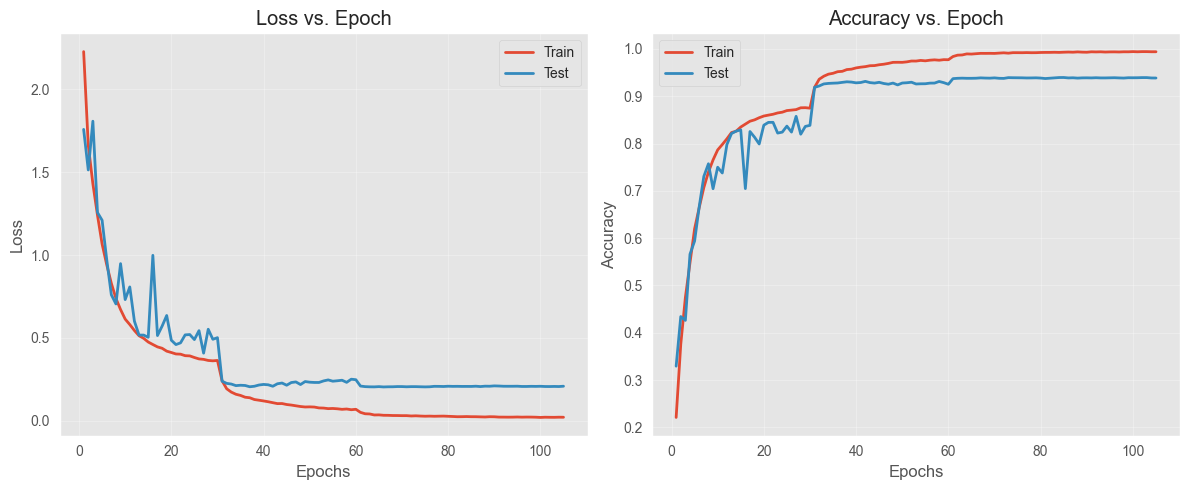

In [7]:
actual_epochs = len(train_losses)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, actual_epochs + 1), train_losses, label='Train', linewidth=2)
plt.plot(range(1, actual_epochs + 1), test_losses, label='Test', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, actual_epochs + 1), train_accuracies, label='Train', linewidth=2)
plt.plot(range(1, actual_epochs + 1), test_accuracies, label='Test', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.show()

In [8]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, report, accuracy, weighted_f1

def plot_conflusion_matrix(cm, classes):
    with plt.style.context('default'):
        plt.figure(figsize=(5, 4))
        sns.set(font_scale=1.0)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion matrix')
        plt.show()

Метрики для текущей модели: 
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1000
           1       0.96      0.97      0.97      1000
           2       0.92      0.92      0.92      1000
           3       0.88      0.87      0.87      1000
           4       0.94      0.96      0.95      1000
           5       0.91      0.90      0.90      1000
           6       0.96      0.96      0.96      1000
           7       0.96      0.95      0.96      1000
           8       0.96      0.96      0.96      1000
           9       0.95      0.96      0.96      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Test accuracy: 0.9396


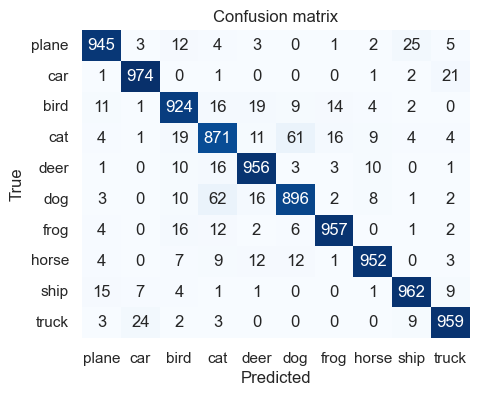

In [11]:
model.load_state_dict(torch.load('models/cifar_reznet_best.pth'))
model.to(device)

cm, report, accuracy, weighted_f1 = evaluate_model(model, test_loader)
print('Метрики для текущей модели: ')
print(report)
print(f'Test accuracy: {accuracy:.4f}')
plot_conflusion_matrix(cm, classes)